In [1]:
from functools import reduce
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn.base
from sklearn.datasets import fetch_california_housing
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from project_functions.estimators import OutliersRemover

# Exploratory analysis

In [2]:
# comprehend data description

california_housing = fetch_california_housing(as_frame=True)

df_housing = california_housing.frame

num_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
geo_cols = ['Latitude', 'Longitude']
y_col = 'MedHouseVal'

pprint(california_housing.DESCR)

df_housing.head()

('.. _california_housing_dataset:\n'
 '\n'
 'California Housing dataset\n'
 '--------------------------\n'
 '\n'
 '**Data Set Characteristics:**\n'
 '\n'
 '    :Number of Instances: 20640\n'
 '\n'
 '    :Number of Attributes: 8 numeric, predictive attributes and the target\n'
 '\n'
 '    :Attribute Information:\n'
 '        - MedInc        median income in block group\n'
 '        - HouseAge      median house age in block group\n'
 '        - AveRooms      average number of rooms per household\n'
 '        - AveBedrms     average number of bedrooms per household\n'
 '        - Population    block group population\n'
 '        - AveOccup      average number of household members\n'
 '        - Latitude      block group latitude\n'
 '        - Longitude     block group longitude\n'
 '\n'
 '    :Missing Attribute Values: None\n'
 '\n'
 'This dataset was obtained from the StatLib repository.\n'
 'https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html\n'
 '\n'
 'The target variable is 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Basic stats

In [3]:
df_housing.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
MedInc,20640.0,3.870671,1.899822,0.499900,1.903800,2.563400,3.534800,4.743250,6.159210,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,13.000000,18.000000,29.000000,37.000000,46.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,3.790884,4.440716,5.229129,6.052381,6.961188,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,0.966415,1.006079,1.048780,1.099526,1.172727,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,510.000000,787.000000,1166.000000,1725.000000,2566.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.075630,2.429741,2.818116,3.282261,3.885273,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.630000,33.930000,34.260000,37.710000,38.480000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-122.290000,-121.800000,-118.490000,-118.010000,-117.250000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,0.823000,1.196000,1.797000,2.647250,3.766000,5.000010


### Check for NAs

In [4]:
df_housing.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

### Explore histograms

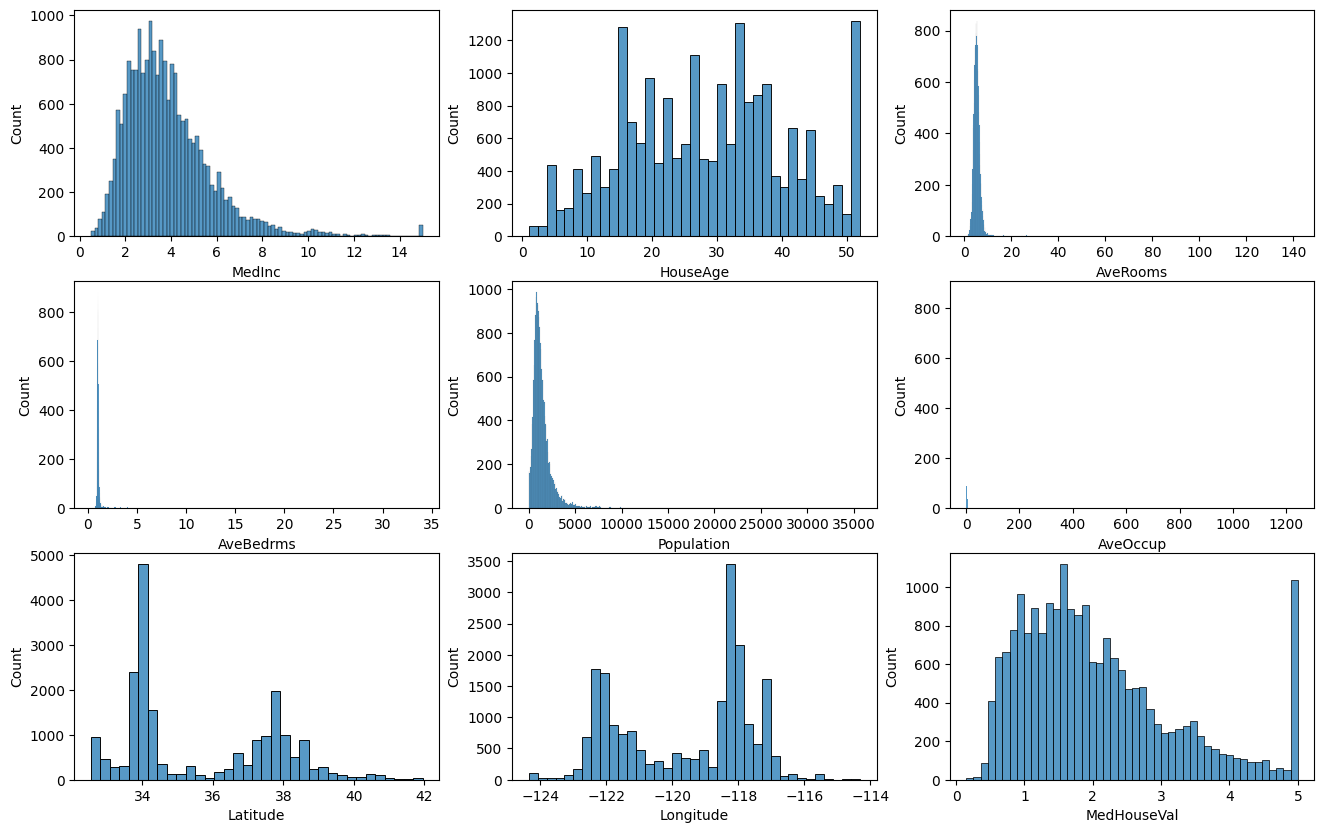

In [5]:
figs, axs = plt.subplots(3, 3, figsize=(16, 10))
axs_iter = iter(axs.reshape(-1))

for col in df_housing.columns:
    sns.histplot(df_housing[col], ax=next(axs_iter))

Quite some outliers can be seen for the AveRooms, AveBedrms, Population and AveOccup features.  
There are also some suspicious peaks at the end of distrubutions of the MedHouseVal, MedInc and HouseAge features. It can be a wrong data (eg. floored to maximum treshold).

### Explore correlations

<Axes: >

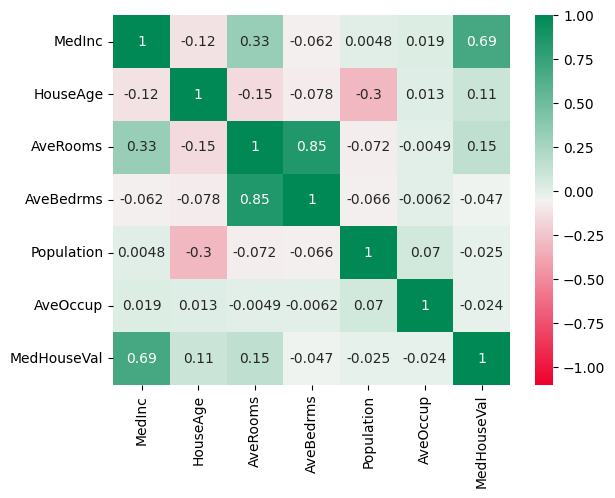

In [6]:
sns.heatmap(
    df_housing.drop(geo_cols, axis=1).corr(),
    vmin=1.0, vmax=-1.0, annot=True, cmap=sns.diverging_palette(370, 145, s=100, as_cmap=True)
    )

Main correlations found: 
-   AveRooms vs. AveBedrms (0.85)
-   MedInc   vs. MedHouseVal (0.69)

### Explore patterns in data

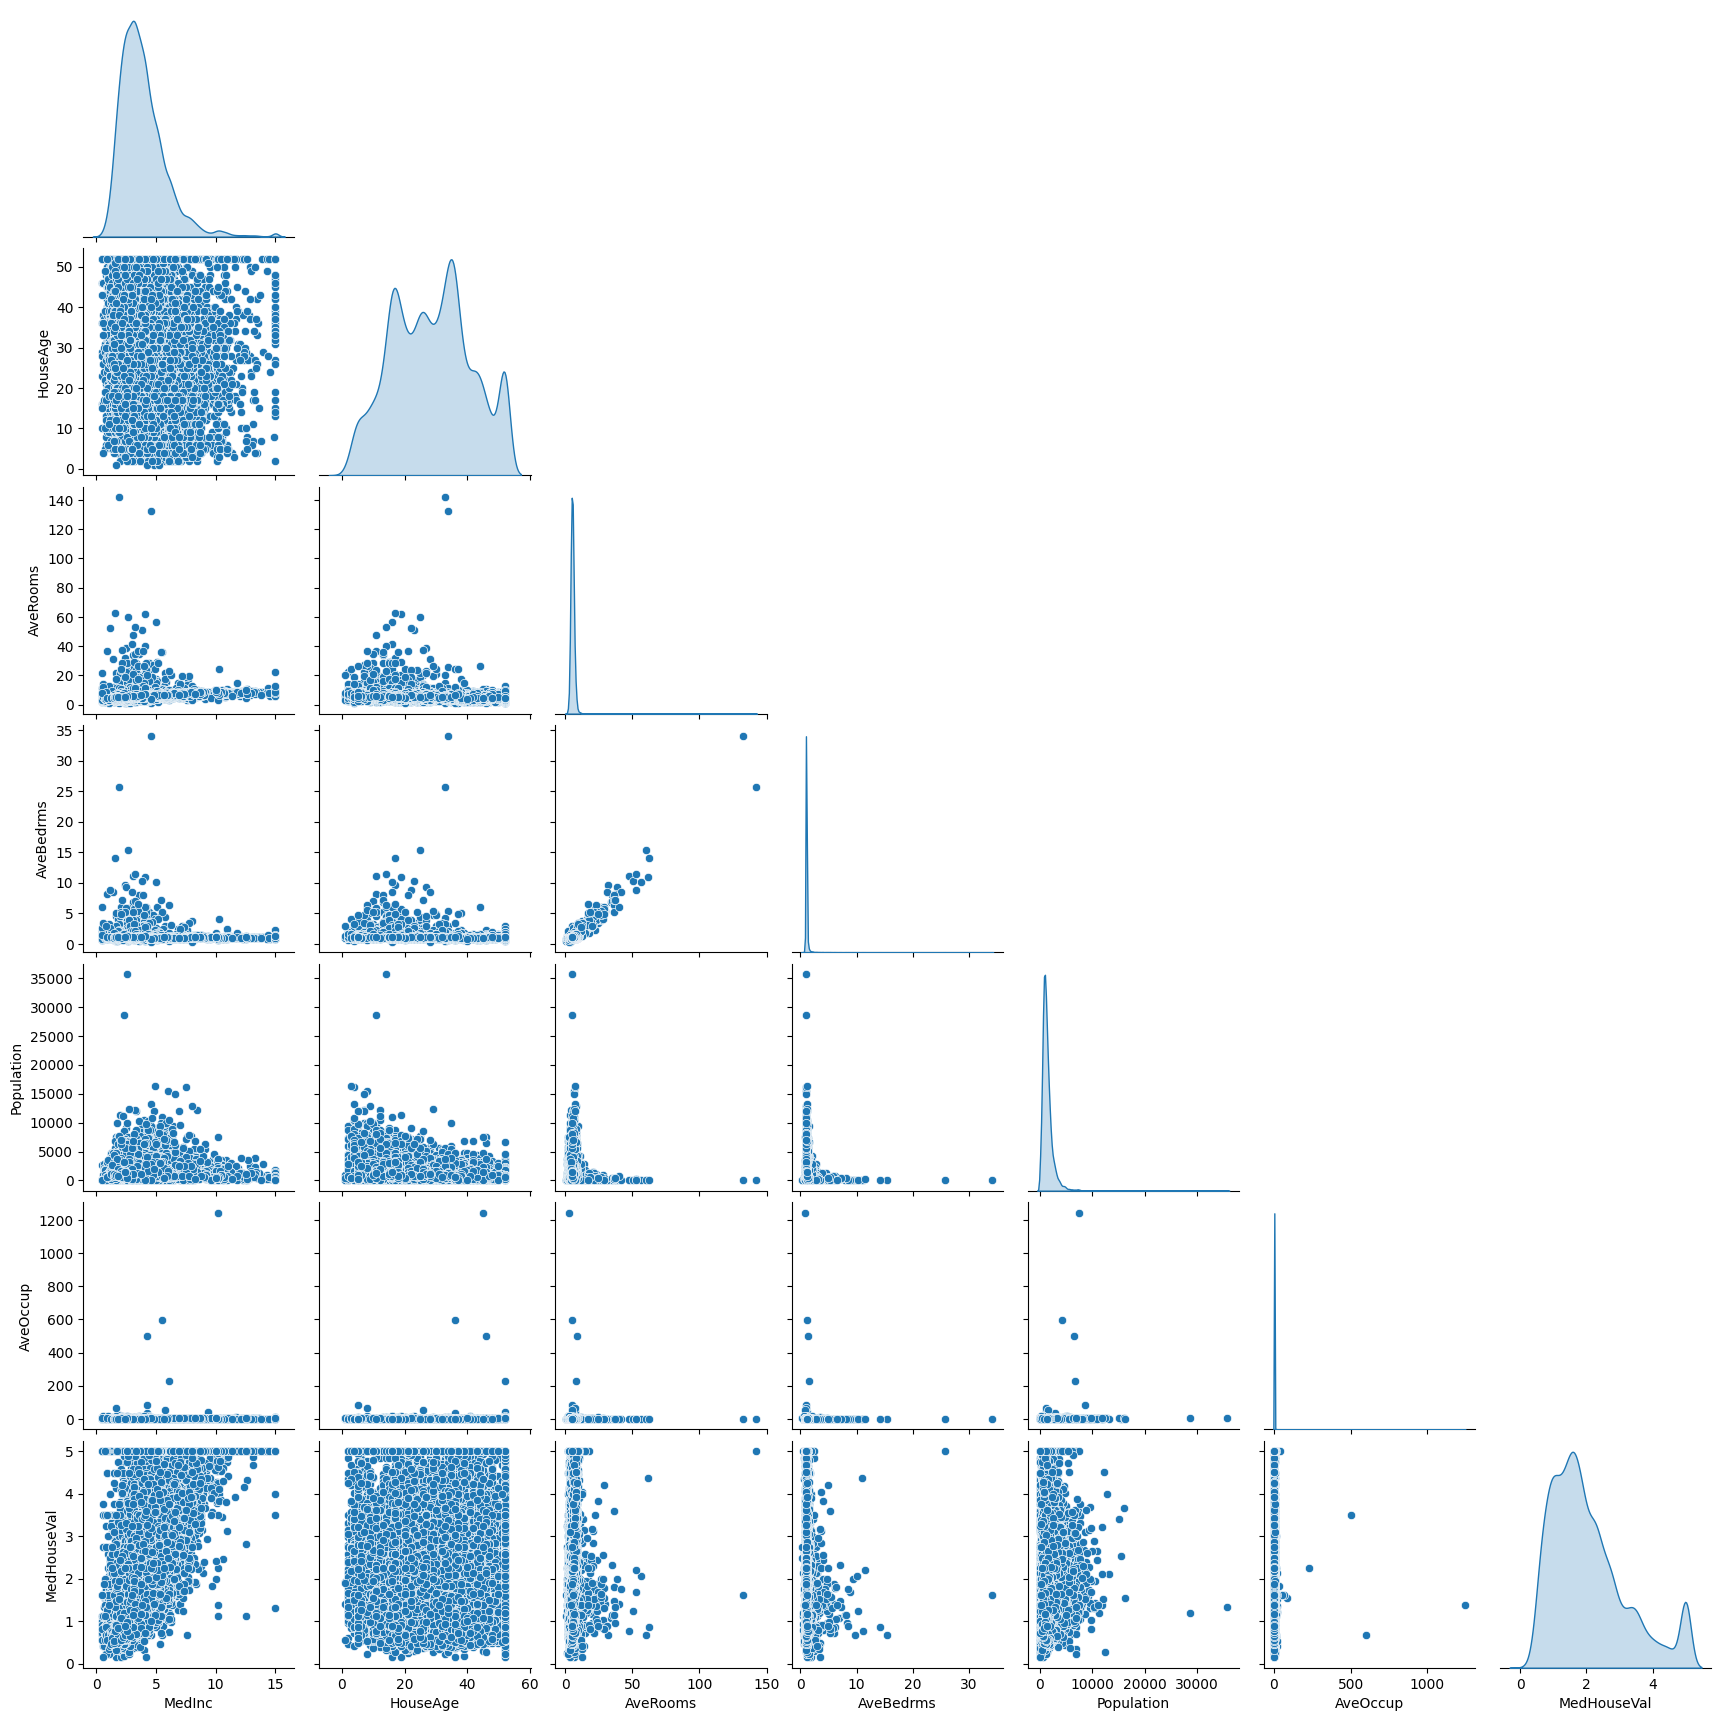

In [7]:
sns.pairplot(df_housing.drop(columns=geo_cols), corner=True, diag_kind='kde')

### Visualize geocoordinate attributes

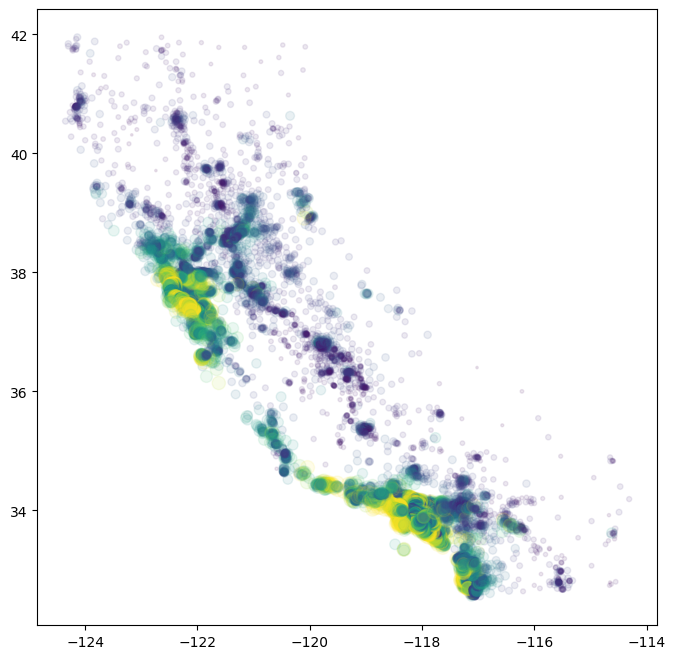

In [8]:
plt.figure(figsize=[8,8])
plt.scatter(df_housing.Longitude, df_housing.Latitude, s=df_housing.MedHouseVal*20, c=df_housing.MedHouseVal, alpha=0.1)

### Conclusions:
1. Quite some outliers can be seen for the AveRooms, AveBedrms, Population and AveOccup features.
2. Suspicious patterns in data visible on histograms: peaks at the end of distrubutions of the MedHouseVal, MedInc and HouseAge features. It can be a wrong data (eg. floored to maximum treshold).
3. Not many correlations between features, mainly AveRooms vs. AveBedrms and MedInc vs. MedHouseVal (the predicted variable).

### Build conditions for outlier removal:

In [9]:
outliers_config = {
    "AveRooms":    lambda x: x.AveRooms < 1,     # self-evident
    "AveRooms":    lambda x: x.AveRooms > 20,    # assumption
    "AveBedrms":   lambda x: x.AveBedrms > 5,    # assumption
    "AveOccup":    lambda x: x.AveOccup < 1,     # self-evident
    "AveOccup":    lambda x: x.AveOccup > 15,    # assumption
    "MedHouseVal": lambda x: x.MedHouseVal >= 5, # weird pattern in data - possibly wrong data
    "MedInc":      lambda x: x.MedInc >= 15,     # weird pattern in data - possibly wrong data
    "HouseAge":    lambda x: x.HouseAge >= 52    # weird pattern in data - possibly wrong data
   }

perc_outliers = reduce(
    lambda a,b: a|b,
    [df_housing.apply(cond, axis=1) for cond in outliers_config.values()]
    ).mean()

pprint(f"Percent of rows with outlier values removed: {perc_outliers:.4f}")

'Percent of rows with outlier values removed: 0.1052'


# Modelling

### Split to test and train datasets

In [10]:
x = df_housing.drop(columns=['MedHouseVal'])
y = df_housing.MedHouseVal

x_train, x_test, y_train, y_test = train_test_split(
  x, y,
  test_size=0.8,
  train_size=0.2, 
  random_state=42
  )

### Baseline model

In [11]:
baseline_model = LinearRegression()
baseline_model.fit(x_train, y_train)

LinearRegression()

### Build transformers and pipelines

- I used a VotingEstimator combining KNeighbors and LinearRegression models to integrate simple and intuitive methods for modeling location impact and numeric data.
- Data preprocessing was incorporated into the Model Pipeline to undergo hyperparameter tuning.

In [12]:
# pick long and lat columns for KNeigbors algorithm and numeric features for linear model

kn_data_picker = ColumnTransformer(
    transformers=[("geo_cols", "passthrough", geo_cols)],
    remainder='drop'
)

lin_data_picker = ColumnTransformer(
    transformers=[("num_cols", "passthrough", num_cols)],
    remainder='drop'
).set_output(transform="pandas")

# remove outliers / wrong data and impute new values

outliers_handler = Pipeline([
    ("remove", OutliersRemover(outliers_config)),
    ("impute", IterativeImputer(random_state=420))
    ])

# KNeighbors pipeline

kn_pip = Pipeline([
    ("data_picker", kn_data_picker),
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=5))
])

# Linear model pipeline 

lin_pip = Pipeline([
    ("data_picker", lin_data_picker),
    ("outliers_handler", outliers_handler),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Voting Regressor to combine KNeighbors and Linear models

vote_pip = VotingRegressor(
  estimators = [
    ("kn_pip", kn_pip), 
    ("lin_pip", lin_pip)
    ]
  )

### Fit and evaluate the model

In [13]:
vote_pip.fit(x_train, y_train)

VotingRegressor(estimators=[('kn_pip',
                             Pipeline(steps=[('data_picker',
                                              ColumnTransformer(transformers=[('geo_cols',
                                                                               'passthrough',
                                                                               ['Latitude',
                                                                                'Longitude'])])),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              KNeighborsRegressor())])),
                            ('lin_pip',
                             Pipeline(steps=[('data_picker',
                                              ColumnTransformer(transformers=[('num_cols',
                                                                               'passthrough',
                                                                               ['MedInc',
                                                                                'HouseAge',
                                                                                'AveRooms'...
                                                               OutliersRemover(outliers_config={'AveBedrms': <function <lambda> at 0x7fe9e0409000>,
                                                                                                'AveOccup': <function <lambda> at 0x7fe9e0409480>,
                                                                                                'AveRooms': <function <lambda> at 0x7fe9e04092d0>,
                                                                                                'HouseAge': <function <lambda> at 0x7fe9e0409630>,
                                                                                                'MedHouseVal': <function <lambda> at 0x7fe9e0409510>,
                                                                                                'MedInc': <function <lambda> at 0x7fe9e04095a0>})),
                                                              ('impute',
                                                               IterativeImputer(random_state=420))])),
                                             ('scaler', StandardScaler()),
                                             ('model', LinearRegression())]))])

In [14]:
# score before hyperparameter tuning and adjustments

vote_pip.score(x_test, y_test)

0.7471326471408297

### Hyperparameter tuning

Start with Grid search to pick best KN model

- scaling - standardization, min-max normalization or no scaling
- n_neighbors - from 1 to 100
- neighbors weights - uniform or distance-weighted
- distance metric - Euclidean (p=1) or Manhattan (p=2)

In [15]:
list(kn_pip.get_params().keys());

kn_tuned = GridSearchCV(
    estimator = kn_pip,
    param_grid={
        "scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
        "model__n_neighbors": list(range(1,10)) + list(range(10,101,10)),
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],
    })

kn_tuned.fit(x_train, y_train)
kn_tuned.best_params_

{'model__n_neighbors': 5,
 'model__p': 1,
 'model__weights': 'distance',
 'scaler': MinMaxScaler()}

In [16]:
list(vote_pip.get_params().keys());

Follow up with Grid search to pick best combined pipeline

- outliers handling - removing outliers and imputation with SimpleImputer, IterativeImputer or no outliers handling  
- scaling - standardization, min-max normalization or no scaling
- regularization - Ridge, Lasso or no regularization  
- voting weights - weights for KNeighbors and LinearRegression, from 0.0 to 1.0

In [17]:
list(vote_pip.get_params().keys());

vote_pip.set_params(kn_pip = kn_tuned.best_estimator_)

vote_pip_tuned = GridSearchCV(
    estimator=vote_pip,
    param_grid={
        "lin_pip__outliers_handler": [outliers_handler.set_params(impute = SimpleImputer()), outliers_handler.set_params(impute = IterativeImputer(random_state=420)), "passthrough"],
        "lin_pip__scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
        "lin_pip__model": [LinearRegression(), RidgeCV()], # LassoCV()
        "weights": [(np.round(w, 1), np.round(1.0 - w, 1)) for w in np.arange(0.0,1.0,0.2)]
        }
      )

# fit and check best hyperparameters

vote_pip_tuned.fit(x_train, y_train)
vote_pip_tuned.best_params_

{'lin_pip__model': LinearRegression(),
 'lin_pip__outliers_handler': Pipeline(steps=[('remove',
                  OutliersRemover(outliers_config={'AveBedrms': <function <lambda> at 0x7fe9e0409000>,
                                                   'AveOccup': <function <lambda> at 0x7fe9e0409480>,
                                                   'AveRooms': <function <lambda> at 0x7fe9e04092d0>,
                                                   'HouseAge': <function <lambda> at 0x7fe9e0409630>,
                                                   'MedHouseVal': <function <lambda> at 0x7fe9e0409510>,
                                                   'MedInc': <function <lambda> at 0x7fe9e04095a0>})),
                 ('impute', IterativeImputer(random_state=420))]),
 'lin_pip__scaler': MinMaxScaler(),
 'weights': (0.8, 0.2)}

In [18]:
vote_pip_tuned.score(x_test, y_test)

0.7650631649725851

**Conclusions:**  

- I used a VotingEstimator combining KNeighbors and LinearRegression models to integrate simple and intuitive methods for modeling location impact and numeric data.
- KNeighbors model was used for geocoordinate data (predicting based on literal neighbors). The model utilized 5 neigboring data points weighted by their distance using the Manhattan metric.
- For numeric data, I employed a simple Linear Regression. My intention was to use possibly the simplest models.
- Optimal model hyperparameters and preprocessing details were obtained during a few rounds of hyperparameter tuning. The model variants were lightweight enough to utilize the GridSearch method.
- A few outliers were identified during EDA (possibly wrong data deduced based on distributions and self-evident errors inconsistent to common sense). They were removed and imputed with a IterativeImputer method.
- MinMaxScaler was chosen as the optimal scaling method for geocoordinate data and StandardScaler was utilized for numeric data.
- The use of regularization methods (Ridge and Lasso Regression) led to subpar results and was therefore rejected.
- According to the R2 score, hyperparameter tuning improved the Model's performance.

### Inspect the model and apply adjustments

In [19]:
list(zip(
    lin_data_picker.fit(x_train).get_feature_names_out(),
    vote_pip_tuned.best_estimator_.estimators_[1]['model'].coef_
    ))

[('num_cols__MedInc', 7.5832530295845535),
 ('num_cols__HouseAge', 0.8656729944280181),
 ('num_cols__AveRooms', -26.161932715560546),
 ('num_cols__AveBedrms', 25.852640331247542),
 ('num_cols__Population', 1.1597634829537693),
 ('num_cols__AveOccup', -0.16422441982172672)]

**Conclusion:**  
Although the AveRooms and AveBedrms features are correlated (according to EDA), their coeficients are opposite and suspiciously high.  
This observation leads me to removing one of the features. I decided to remove AveRooms as its coefficient is negative, which goes against the common sense - more rooms should boost the value.

In [20]:
cols_to_reduce = ['AveRooms',]

lin_data_picker_adjusted = ColumnTransformer(
  transformers=[("drop_cols", "drop", geo_cols + cols_to_reduce)],
  remainder='passthrough'
).set_output(transform='pandas')

adjusted_pip = sklearn.base.clone(vote_pip_tuned.best_estimator_)
adjusted_pip.set_params(lin_pip__data_picker = lin_data_picker_adjusted)

VotingRegressor(estimators=[('kn_pip',
                             Pipeline(steps=[('data_picker',
                                              ColumnTransformer(transformers=[('geo_cols',
                                                                               'passthrough',
                                                                               ['Latitude',
                                                                                'Longitude'])])),
                                             ('scaler', MinMaxScaler()),
                                             ('model',
                                              KNeighborsRegressor(p=1,
                                                                  weights='distance'))])),
                            ('lin_pip',
                             Pipeline(steps=[('data_picker',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('drop_cols',...
                                                                                                'AveOccup': <function <lambda> at 0x7fe9e0409480>,
                                                                                                'AveRooms': <function <lambda> at 0x7fe9e04092d0>,
                                                                                                'HouseAge': <function <lambda> at 0x7fe9e0409630>,
                                                                                                'MedHouseVal': <function <lambda> at 0x7fe9e0409510>,
                                                                                                'MedInc': <function <lambda> at 0x7fe9e04095a0>})),
                                                              ('impute',
                                                               IterativeImputer(random_state=420))])),
                                             ('scaler', MinMaxScaler()),
                                             ('model', LinearRegression())]))],
                weights=(0.8, 0.2))

In [21]:
# refit adjusted pipeline

adjusted_pip.fit(x_train, y_train)
adjusted_pip.score(x_test, y_test)

0.7671060617395953

In [22]:
# inspect adjusted model

list(zip(
    lin_data_picker_adjusted.fit(x_train).get_feature_names_out(),
    adjusted_pip.estimators_[1]['model'].coef_
    ))

[('remainder__MedInc', 6.229445115941713),
 ('remainder__HouseAge', 0.9230839153732375),
 ('remainder__AveBedrms', 2.21588915029601),
 ('remainder__Population', 1.4600937774944658),
 ('remainder__AveOccup', -0.7960945524149232)]

**Conclusion:**  
Removing AveRooms feature impacted model's performance positively (according to the R2 score).  
Remainder features and their coefficients look fine.

## Evaluation

### Model interpretation

- The optimal voting weigths for KNeigbors and LinearRegression, derived through hyperparameter tuning, were set to 0.8 to 0.2 respectively. This implies that the most impactful features in the model were geocoordinate data, aka the location.
- This aligns with the common adage that the key factors for house prices are "location, location, location". ;)
- The most crucial numeric feature was Median Income, followed by Average Bedrooms.

### Visualize and evaluate model's performance

,Baseline,Final
observed_median,1.798500,1.798500
predicted_median,2.025461,1.862070
MAE,0.529594,0.369015
MSE,0.521844,0.309269
MAPE,0.318116,0.206454
R2_score,0.607027,0.767106


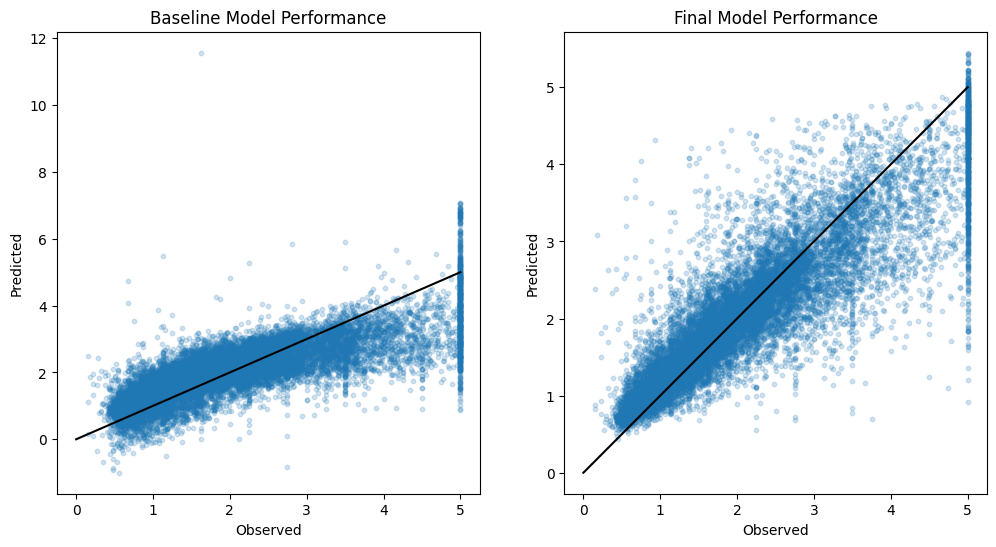

In [23]:
# First - baseline model, for comparison

figs, axs = plt.subplots(1, 2, figsize=[12,6])

y_pred_baseline = baseline_model.predict(x_test)


axs[0].scatter(y_test, y_pred_baseline, alpha=0.2, s=10)
axs[0].plot(range(6), range(6), color="black")
axs[0].set_title("Baseline Model Performance")
axs[0].set_xlabel("Observed")
axs[0].set_ylabel("Predicted")

# Final model evaluation

y_pred = adjusted_pip.predict(x_test)

axs[1].scatter(y_test, y_pred, alpha=0.2, s=10)
axs[1].plot(range(6), range(6), color="black")
axs[1].set_title("Final Model Performance")
axs[1].set_xlabel("Observed")
axs[1].set_ylabel("Predicted")

eval_metrics_labels = [
    "observed_median",
    "predicted_median",
    "MAE",
    "MSE",
    "MAPE",
    "R2_score"
]

eval_metrics_baseline = [
    np.median(y_test),
    np.median(y_pred_baseline),
    metrics.mean_absolute_error(y_test, y_pred_baseline),
    metrics.mean_squared_error(y_test, y_pred_baseline),
    metrics.mean_absolute_percentage_error(y_test, y_pred_baseline),
    metrics.r2_score(y_test, y_pred_baseline)
    ]

eval_metrics_final = [
    np.median(y_test),
    np.median(y_pred),
    metrics.mean_absolute_error(y_test, y_pred),
    metrics.mean_squared_error(y_test, y_pred),
    metrics.mean_absolute_percentage_error(y_test, y_pred),
    metrics.r2_score(y_test, y_pred)
]

pd.DataFrame({"Baseline": eval_metrics_baseline, "Final": eval_metrics_final}, index=eval_metrics_labels)